## Preprocessing

In [1]:
import pandas as pd
import numpy as np
import seaborn 
from sklearn.preprocessing import OneHotEncoder
import pandas as pd
import pickle

In [2]:
trainData = pd.read_csv('data/train.csv')
testData = pd.read_csv('data/test.csv')
sampleSubmission = pd.read_csv('data/sample_submission.csv')

print("Train Data Shape:", trainData.shape)
print("Test Data Shape:", testData.shape)
print("Sample Submission Shape:", sampleSubmission.shape)

Train Data Shape: (80000, 31)
Test Data Shape: (20000, 30)
Sample Submission Shape: (20000, 2)


In [3]:
# Label datasets for later separation
trainData['is_train'] = 1
testData['is_train'] = 0
testData['Default 12 Flag'] = np.nan  # Placeholder for uniform structure

# Combine for uniform feature engineering
data = pd.concat([trainData, testData], axis=0)


### Deriving Extra Features from dataset

In [4]:

# Convert dates
data['Date of Birth'] = pd.to_datetime(data['Date of Birth'])
data['Application Date'] = pd.to_datetime(data['Application Date'])

# Derive Age
data['Age'] = (data['Application Date'] - data['Date of Birth']).dt.days // 365

data['is_weekend'] = data['Application Date'].dt.weekday.isin([5, 6]).astype(int)
data['Application_Month'] = data['Application Date'].dt.month

data.drop(columns=['Date of Birth', 'Application Date', 'Application Time', 'ID'], inplace=True)

# Derived Features
data['Debt_to_Income'] = data['Declared Amount of Unsecured Loans'] / (data['Total Annual Income'] + 1)
data['Loan_Count_per_Dependent'] = data['Number of Unsecured Loans'] / (1 + data['Number of Dependents'])
data['Rent_to_Income'] = data['Rent Burden Amount'] / (data['Total Annual Income'] + 1)
data['Loan_Amount_per_Income'] = data['Amount of Unsecured Loans'] / (data['Total Annual Income'] + 1)
data['Declared_Loan_Amount_Diff'] = abs(data['Declared Amount of Unsecured Loans'] - data['Amount of Unsecured Loans'])
data['Declared_Loan_Count_Diff'] = abs(data['Declared Number of Unsecured Loans'] - data['Number of Unsecured Loans'])
data['Desired_Credit_to_Income'] = data['Application Limit Amount(Desired)'] / (data['Total Annual Income'] + 1)
data['Employment_Tenure_to_Age'] = data['Duration of Employment at Company (Months)'] / (data['Age'] * 12 + 1)
data['Short_Residence_Flag'] = (data['Duration of Residence (Months)'] < 12).astype(int)
data['Short_Employment_Flag'] = (data['Duration of Employment at Company (Months)'] < 6).astype(int)
data['Children_to_Dependent_Ratio'] = data['Number of Dependent Children'] / (1 + data['Number of Dependents'])
data['Household_Size'] = data['Number of Dependents'] + 1
data['Living_Alone_Flag'] = ((data['Family Composition Type'] == 0) | (data['Living Arrangement Type'] == 0)).astype(int)
data['Gender_Marital_Combo'] = data['Gender'].astype(str) + "_" + data['Single/Married Status'].astype(str)
data['Income_per_Month_Employment'] = data['Total Annual Income'] / (data['Duration of Employment at Company (Months)'] + 1)
data['Insurance_Employment_Combo'] = data['Insurance Job Type'].astype(str) + "_" + data['Employment Status Type'].astype(str)
data['Company_Industry_Combo'] = data['Company Size Category'].astype(str) + "_" + data['Industry Type'].astype(str)



In [5]:
derived_features = [
    'Age',
    'is_weekend',
    'Application_Month',
    'Debt_to_Income',
    'Loan_Count_per_Dependent',
    'Rent_to_Income',
    'Loan_Amount_per_Income',
    'Declared_Loan_Amount_Diff',
    'Declared_Loan_Count_Diff',
    'Desired_Credit_to_Income',
    'Employment_Tenure_to_Age',
    'Short_Residence_Flag',
    'Short_Employment_Flag',
    'Children_to_Dependent_Ratio',
    'Household_Size',
    'Living_Alone_Flag',
    'Gender_Marital_Combo',
    'Income_per_Month_Employment',
    'Insurance_Employment_Combo',
    'Company_Industry_Combo'
]

In [6]:
# Re-separate train and test
trainData = data[data['is_train'] == 1].drop(columns=['is_train'])
testData = data[data['is_train'] == 0].drop(columns=['is_train', 'Default 12 Flag'])

# Optionally, inspect or save
print("Enhanced train shape:", trainData.shape)
print("Enhanced test shape:", testData.shape)

Enhanced train shape: (80000, 47)
Enhanced test shape: (20000, 46)


In [7]:
print(trainData.columns)

Index(['Major Media Code', 'Internet Details', 'Reception Type Category',
       'Gender', 'Single/Married Status', 'Number of Dependents',
       'Number of Dependent Children', 'JIS Address Code', 'Residence Type',
       'Name Type', 'Rent Burden Amount', 'Duration of Residence (Months)',
       'Family Composition Type', 'Living Arrangement Type',
       'Insurance Job Type', 'Employment Type', 'Employment Status Type',
       'Industry Type', 'Company Size Category',
       'Duration of Employment at Company (Months)', 'Total Annual Income',
       'Declared Number of Unsecured Loans',
       'Declared Amount of Unsecured Loans', 'Number of Unsecured Loans',
       'Amount of Unsecured Loans', 'Application Limit Amount(Desired)',
       'Default 12 Flag', 'Age', 'is_weekend', 'Application_Month',
       'Debt_to_Income', 'Loan_Count_per_Dependent', 'Rent_to_Income',
       'Loan_Amount_per_Income', 'Declared_Loan_Amount_Diff',
       'Declared_Loan_Count_Diff', 'Desired_Credit_to_

In [8]:
# Check the number of values in column 'Default 12 flag' of train data with value 0
zero_count = (trainData['Default 12 Flag'] == 0).sum()
print("Number of values in 'Default 12 flag' column of train data with value 0:", zero_count)

# Check the number of values in 'Default 12 flag' column of train data with value 1
one_count = (trainData['Default 12 Flag'] == 1).sum()
print("Number of values in last column of train data with value 1:", one_count)

Number of values in 'Default 12 flag' column of train data with value 0: 72069
Number of values in last column of train data with value 1: 7931


In [9]:
data = trainData.copy()

In [10]:
num_cols = trainData.copy()
# remove ID and Default 12 Flag from num_cols
num_cols = num_cols.drop(['Default 12 Flag'], axis=1)
num_cols = num_cols.columns.tolist()

In [11]:
numericalCol = ['Declared Amount of Unsecured Loans', 'Number of Unsecured Loans', 'Number of Dependents', 'Number of Dependent Children', 'Rent Burden Amount', 'Duration of Residence (Months)', 'Duration of Employment at Company (Months)', 'Total Annual Income', 'Declared Number of Unsecured Loans' ,'Declared Amount of Unsecured Loans', 'Number of Unsecured Loans', 'Amount of Unsecured Loans', 'Application Limit Amount(Desired)', 'Age', 'Debt_to_Income', 'Loan_Count_per_Dependent', 'Rent_to_Income', 'Loan_Amount_per_Income', 'Declared_Loan_Amount_Diff', 'Declared_Loan_Count_Diff', 'Desired_Credit_to_Income', 'Employment_Tenure_to_Age', 'Children_to_Dependent_Ratio', 'Household_Size', 'Income_per_Month_Employment']
# normalise the numerical columns using StandardScaler 

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
data[numericalCol] = scaler.fit_transform(data[numericalCol])

print(data[numericalCol].head())

# print(len(numericalCol))

   Declared Amount of Unsecured Loans  Number of Unsecured Loans  \
0                           -0.000118                   0.878879   
1                           -0.015249                  -1.004147   
2                           -0.017410                  -1.004147   
3                           -0.014528                  -0.062634   
4                           -0.013087                  -1.004147   

   Number of Dependents  Number of Dependent Children  Rent Burden Amount  \
0             -0.549792                     -0.482562           -0.051327   
1              2.525429                      2.946351           -0.055762   
2              1.756624                     -0.482562           -0.048666   
3              3.294234                      2.946351           -0.051771   
4             -0.549792                     -0.482562           -0.042678   

   Duration of Residence (Months)  Duration of Employment at Company (Months)  \
0                       -0.781675              

In [12]:
categoricalCol = ['Major Media Code', 'Internet Details', 'Reception Type Category', 'Gender', 'Single/Married Status', 'Residence Type', 'Name Type', 'Family Composition Type', 'Living Arrangement Type', 'Insurance Job Type', 'Employment Type', 'Employment Status Type', 'Industry Type','Company Size Category', 'Short_Residence_Flag', 'Short_Employment_Flag', 'Living_Alone_Flag', 'Gender_Marital_Combo', 'Insurance_Employment_Combo', 'Company_Industry_Combo']

print(len(categoricalCol)+len(numericalCol))  # total number of features after adding 'Age' column
# 31 - Class - age - id

# the categorical columns need to be encoded using one hot encoding

# Create OneHotEncoder compatible with different sklearn versions (sparse vs sparse_output)
try:
    encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')
except TypeError:
    encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

# Fit-transform the categorical columns
encoded_cats = encoder.fit_transform(data[categoricalCol])
print("Encoded categorical shape:", encoded_cats.shape)

# Get feature names if available and attach back to dataframe
try:
    feature_names = encoder.get_feature_names_out(categoricalCol)
except Exception:
    feature_names = [f'ohe_{i}' for i in range(encoded_cats.shape[1])]

ohe_df = pd.DataFrame(encoded_cats, columns=feature_names, index=data.index)
data = pd.concat([data.drop(columns=categoricalCol), ohe_df], axis=1)
print('Data with OHE shape:', data.shape)
print(data.head())

# Save encoder for later use on test/validation
with open('ohe_encoder.pkl','wb') as f:
    pickle.dump(encoder, f)


45
Encoded categorical shape: (80000, 268)
Data with OHE shape: (80000, 295)
   Number of Dependents  Number of Dependent Children  JIS Address Code  \
0             -0.549792                     -0.482562           46201.0   
1              2.525429                      2.946351           45204.0   
2              1.756624                     -0.482562           45204.0   
3              3.294234                      2.946351           45201.0   
4             -0.549792                     -0.482562           45201.0   

   Rent Burden Amount  Duration of Residence (Months)  \
0           -0.051327                       -0.781675   
1           -0.055762                       -0.082070   
2           -0.048666                       -0.597568   
3           -0.051771                        0.050486   
4           -0.042678                       -0.089435   

   Duration of Employment at Company (Months)  Total Annual Income  \
0                                   -0.471743             1

In [13]:
# compute the correlation of each feature with the target column 'Default 12 Flag'

corr_matrix = data.corr()
print("Correlation matrix shape:", corr_matrix.shape)

# Display the correlation matrix
print(corr_matrix)


# correlations = data.corr()['Default 12 Flag'].sort_values()
# print("Top 5 features with highest positive correlation:")
# print(correlations)  # last 5 + target itself


Correlation matrix shape: (295, 295)
                                Number of Dependents  \
Number of Dependents                        1.000000   
Number of Dependent Children                0.855754   
JIS Address Code                            0.042211   
Rent Burden Amount                          0.008089   
Duration of Residence (Months)              0.010774   
...                                              ...   
Company_Industry_Combo_9_6                  0.003138   
Company_Industry_Combo_9_7                  0.001112   
Company_Industry_Combo_9_8                  0.007372   
Company_Industry_Combo_9_9                 -0.000120   
Company_Industry_Combo_9_99                 0.005368   

                                Number of Dependent Children  \
Number of Dependents                                0.855754   
Number of Dependent Children                        1.000000   
JIS Address Code                                    0.052241   
Rent Burden Amount                

## Over-Sampling

In [14]:
# count number of class 1 
class_1_count = (data['Default 12 Flag'] == 1).sum()
print("Number of values in last column of train data with value 1:", class_1_count)

Number of values in last column of train data with value 1: 7931


In [15]:
import sklearn.cluster as cluster
import os
import matplotlib.pyplot as plt

from ydata_synthetic.synthesizers.regular import wgangp
from ydata_synthetic.synthesizers import ModelParameters, TrainParameters
from ydata_synthetic.postprocessing.regular.inverse_preprocesser import inverse_transform

model = wgangp.model.WGAN_GP


In [16]:
class_1_data = data.loc[ data['Default 12 Flag']==1 ].copy()
print(class_1_data.shape)


# We define a K-means clustering method using sklearn, and declare that
# we want 2 clusters. We then apply this algorithm (fit_predict) to our train_data
# We essentially get an array of 7931 rows ('labels') having values either 0 or 1 for the 2 clustered classes.

algorithm = cluster.KMeans
args, kwds = (), {'n_clusters':2, 'random_state':0}
num_cols = list(class_1_data.columns[ class_1_data.columns != 'Default 12 Flag' ])
labels = algorithm(*args, **kwds).fit_predict(class_1_data[num_cols])

# Get the count of both classes
print( pd.DataFrame( [ [sum(labels==i)] for i in np.unique(labels) ], columns=['count'], index=np.unique(labels) ) )

# Assign the k-means clustered classes' labels to the a seperate copy of train data 'fraud_w_classes'
fraud_w_classes = class_1_data.copy()
fraud_w_classes['Default 12 Flag'] = labels


(7931, 295)
   count
0   3563
1   4368


In [17]:
noise_dim = 293
dim = 128
batch_size = 128

log_step = 100
epochs = 500+1
learning_rate = 5e-4
beta_1 = 0.5
beta_2 = 0.9
models_dir = './cache'

#Setting the GAN model parameters and the training step parameters
gan_args = ModelParameters(batch_size=batch_size,
                           lr=learning_rate,
                           betas=(beta_1, beta_2),
                           noise_dim=noise_dim,
                           layers_dim=dim)

train_args = TrainParameters(epochs=epochs,
                             sample_interval=log_step)

In [18]:
from ydata_synthetic.synthesizers.regular import wgangp
help(wgangp.model.WGAN_GP)

Help on class WGAN_GP in module ydata_synthetic.synthesizers.regular.wgangp.model:

class WGAN_GP(ydata_synthetic.synthesizers.base.BaseGANModel)
 |  WGAN_GP(model_parameters, n_generator: int = 1, n_critic: int = 1, gradient_penalty_weight: int = 10)
 |  
 |  Method resolution order:
 |      WGAN_GP
 |      ydata_synthetic.synthesizers.base.BaseGANModel
 |      ydata_synthetic.synthesizers.base.BaseModel
 |      abc.ABC
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __init__(self, model_parameters, n_generator: int = 1, n_critic: int = 1, gradient_penalty_weight: int = 10)
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 |  c_lossfn(self, real)
 |      Compute critic loss.
 |      
 |      Args:
 |          real: real data
 |      
 |      Returns:
 |          critic loss
 |  
 |  define_gan(self, activation_info: Optional[NamedTuple] = None)
 |      Define the trainable model components.
 |      
 |      Args:
 |          activation_info (

In [ ]:
synthesizer = model(gan_args,  n_critic=2)
# how can i get to know about the synthesizer.fit arguments

cat_cols = ['Default 12 Flag']
print(synthesizer.fit.__code__.co_varnames)
synthesizer.fit(data = fraud_w_classes, train_arguments = train_args, num_cols = num_cols, cat_cols = cat_cols)

('self', 'data', 'train_arguments', 'num_cols', 'cat_cols', 'processed_data', 'optimizers', 'iterations', 'train_summary_writer', 'epoch', '_', 'batch_data', 'cri_loss', 'ge_loss', 'model_checkpoint_base_name')


  0%|          | 1/501 [00:04<41:32,  4.98s/it]

Epoch: 0 | disc_loss: -0.04018683731555939 | gen_loss: -0.030925478786230087


  0%|          | 2/501 [00:06<23:03,  2.77s/it]

Epoch: 1 | disc_loss: -0.11922679841518402 | gen_loss: 0.0014898923691362143


  1%|          | 3/501 [00:07<17:05,  2.06s/it]

Epoch: 2 | disc_loss: -0.08459247648715973 | gen_loss: 0.031845830380916595


  1%|          | 4/501 [00:08<14:12,  1.71s/it]

Epoch: 3 | disc_loss: -0.11242157220840454 | gen_loss: 0.004820480477064848


  1%|          | 5/501 [00:09<12:35,  1.52s/it]

Epoch: 4 | disc_loss: -0.11770443618297577 | gen_loss: -0.01235773041844368


  1%|          | 6/501 [00:10<11:37,  1.41s/it]

Epoch: 5 | disc_loss: -0.1331031322479248 | gen_loss: 0.0034700571559369564


  1%|▏         | 7/501 [00:12<11:10,  1.36s/it]

Epoch: 6 | disc_loss: -0.14505015313625336 | gen_loss: 0.01009054109454155


  2%|▏         | 8/501 [00:13<10:51,  1.32s/it]

Epoch: 7 | disc_loss: -0.16145896911621094 | gen_loss: 0.0019330186769366264


  2%|▏         | 9/501 [00:14<10:31,  1.28s/it]

Epoch: 8 | disc_loss: -0.1684657782316208 | gen_loss: 0.020688079297542572


  2%|▏         | 10/501 [00:15<10:17,  1.26s/it]

Epoch: 9 | disc_loss: -0.16798892617225647 | gen_loss: 0.008281593210995197


  2%|▏         | 11/501 [00:17<10:05,  1.24s/it]

Epoch: 10 | disc_loss: -0.17389217019081116 | gen_loss: 0.011222145520150661


  2%|▏         | 12/501 [00:18<09:56,  1.22s/it]

Epoch: 11 | disc_loss: -0.17593242228031158 | gen_loss: 0.004235774744302034


  3%|▎         | 13/501 [00:19<09:55,  1.22s/it]

Epoch: 12 | disc_loss: -0.1739405244588852 | gen_loss: 0.0008820993825793266


  3%|▎         | 14/501 [00:20<09:52,  1.22s/it]

Epoch: 13 | disc_loss: -0.1872619390487671 | gen_loss: -0.002971199806779623


  3%|▎         | 15/501 [00:21<09:46,  1.21s/it]

Epoch: 14 | disc_loss: -0.19342456758022308 | gen_loss: -0.005636660847812891


  3%|▎         | 16/501 [00:23<09:41,  1.20s/it]

Epoch: 15 | disc_loss: -0.19200579822063446 | gen_loss: -0.0013893973082304


  3%|▎         | 17/501 [00:24<09:32,  1.18s/it]

Epoch: 16 | disc_loss: -0.19084709882736206 | gen_loss: -0.017713095992803574


  4%|▎         | 18/501 [00:25<09:31,  1.18s/it]

Epoch: 17 | disc_loss: -0.18979911506175995 | gen_loss: 0.009027732536196709


  4%|▍         | 19/501 [00:26<09:25,  1.17s/it]

Epoch: 18 | disc_loss: -0.17977267503738403 | gen_loss: 0.01732996664941311


  4%|▍         | 20/501 [00:27<09:25,  1.17s/it]

Epoch: 19 | disc_loss: -0.13592469692230225 | gen_loss: -0.0011770683340728283


  4%|▍         | 21/501 [00:28<09:24,  1.18s/it]

Epoch: 20 | disc_loss: -0.1245233342051506 | gen_loss: 0.005333397537469864


  4%|▍         | 22/501 [00:30<09:26,  1.18s/it]

Epoch: 21 | disc_loss: -0.1904982179403305 | gen_loss: -0.01521565206348896


  5%|▍         | 23/501 [00:31<09:21,  1.17s/it]

Epoch: 22 | disc_loss: -0.1660936027765274 | gen_loss: 0.01515050046145916


  5%|▍         | 24/501 [00:32<09:19,  1.17s/it]

Epoch: 23 | disc_loss: -0.18758389353752136 | gen_loss: -0.0022370738442987204


  5%|▍         | 25/501 [00:33<09:16,  1.17s/it]

Epoch: 24 | disc_loss: -0.1886482834815979 | gen_loss: -0.008725102990865707


  5%|▌         | 26/501 [00:34<09:21,  1.18s/it]

Epoch: 25 | disc_loss: -0.18562477827072144 | gen_loss: -0.021947864443063736


  5%|▌         | 27/501 [00:35<09:14,  1.17s/it]

Epoch: 26 | disc_loss: -0.18221551179885864 | gen_loss: -0.014637406915426254


  6%|▌         | 28/501 [00:37<09:15,  1.17s/it]

Epoch: 27 | disc_loss: -0.17302308976650238 | gen_loss: -0.022753790020942688


  6%|▌         | 29/501 [00:38<09:29,  1.21s/it]

Epoch: 28 | disc_loss: -0.18041852116584778 | gen_loss: -0.0264009740203619


  6%|▌         | 30/501 [00:39<09:31,  1.21s/it]

Epoch: 29 | disc_loss: -0.17101672291755676 | gen_loss: -0.015004294924438


  6%|▌         | 31/501 [00:40<09:31,  1.22s/it]

Epoch: 30 | disc_loss: -0.15583579242229462 | gen_loss: -0.023473095148801804


  6%|▋         | 32/501 [00:42<09:26,  1.21s/it]

Epoch: 31 | disc_loss: -0.17560486495494843 | gen_loss: -0.028441786766052246


  7%|▋         | 33/501 [00:43<09:18,  1.19s/it]

Epoch: 32 | disc_loss: -0.17002956569194794 | gen_loss: -0.03183677792549133


  7%|▋         | 34/501 [00:44<09:13,  1.19s/it]

Epoch: 33 | disc_loss: -0.15813785791397095 | gen_loss: -0.017288360744714737


  7%|▋         | 35/501 [00:45<09:11,  1.18s/it]

Epoch: 34 | disc_loss: -0.17463642358779907 | gen_loss: -0.024770401418209076


  7%|▋         | 36/501 [00:46<09:11,  1.19s/it]

Epoch: 35 | disc_loss: -0.1716790646314621 | gen_loss: -0.027982022613286972


  7%|▋         | 37/501 [00:47<09:04,  1.17s/it]

Epoch: 36 | disc_loss: -0.1747627556324005 | gen_loss: -0.041044361889362335


  8%|▊         | 38/501 [00:49<09:17,  1.20s/it]

Epoch: 37 | disc_loss: -0.16432048380374908 | gen_loss: -0.04808369278907776


  8%|▊         | 39/501 [00:50<09:16,  1.20s/it]

Epoch: 38 | disc_loss: -0.15733689069747925 | gen_loss: -0.04769483208656311


  8%|▊         | 40/501 [00:51<09:16,  1.21s/it]

Epoch: 39 | disc_loss: -0.11989392340183258 | gen_loss: -0.05391569435596466


  8%|▊         | 41/501 [00:52<09:18,  1.21s/it]

Epoch: 40 | disc_loss: -0.15503396093845367 | gen_loss: -0.03655857965350151


  8%|▊         | 42/501 [00:54<10:00,  1.31s/it]

Epoch: 41 | disc_loss: -0.1610834151506424 | gen_loss: -0.03918773680925369


  9%|▊         | 43/501 [00:55<10:30,  1.38s/it]

Epoch: 42 | disc_loss: -0.15497241914272308 | gen_loss: -0.04399000480771065


  9%|▉         | 44/501 [00:57<10:45,  1.41s/it]

Epoch: 43 | disc_loss: -0.16151218116283417 | gen_loss: -0.04673122987151146


  9%|▉         | 45/501 [00:58<10:52,  1.43s/it]

Epoch: 44 | disc_loss: -0.15233910083770752 | gen_loss: -0.04685612767934799


  9%|▉         | 46/501 [01:00<11:01,  1.45s/it]

Epoch: 45 | disc_loss: -0.1576361209154129 | gen_loss: -0.027423005551099777


  9%|▉         | 47/501 [01:01<11:08,  1.47s/it]

Epoch: 46 | disc_loss: -0.15699228644371033 | gen_loss: -0.05756185203790665


 10%|▉         | 48/501 [01:03<11:16,  1.49s/it]

Epoch: 47 | disc_loss: -0.16320088505744934 | gen_loss: -0.03986310586333275


 10%|▉         | 49/501 [01:04<11:18,  1.50s/it]

Epoch: 48 | disc_loss: -0.15579208731651306 | gen_loss: -0.046547528356313705


 10%|▉         | 50/501 [01:06<11:14,  1.50s/it]

Epoch: 49 | disc_loss: -0.15083283185958862 | gen_loss: -0.04751156270503998


 10%|█         | 51/501 [01:07<11:13,  1.50s/it]

Epoch: 50 | disc_loss: -0.1468142718076706 | gen_loss: -0.051009051501750946


 10%|█         | 52/501 [01:09<11:08,  1.49s/it]

Epoch: 51 | disc_loss: -0.1343093067407608 | gen_loss: -0.06265793740749359


 11%|█         | 53/501 [01:10<11:10,  1.50s/it]

Epoch: 52 | disc_loss: -0.12971991300582886 | gen_loss: -0.05752167850732803


In [ ]:
synthesizer.generator.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(128, 293)]              0         
                                                                 
 dense (Dense)               (128, 128)                37632     
                                                                 
 dense_1 (Dense)             (128, 256)                33024     
                                                                 
 dense_2 (Dense)             (128, 512)                131584    
                                                                 
 dense_3 (Dense)             (128, 296)                151848    
                                                                 
Total params: 354088 (1.35 MB)
Trainable params: 354088 (1.35 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
if not os.path.exists("./saved/gan"):
    os.makedirs("./saved/gan")
synthesizer.save(path="./saved/gan/generator_fraud.pkl")

c:\Users\offic\miniconda3\envs\py38\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:486: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


In [ ]:
models = {'GAN': ['GAN', False, synthesizer.generator]}

In [ ]:
synthetic_fraud = synthesizer.sample(50000)

Synthetic data generation: 100%|██████████| 391/391 [00:01<00:00, 313.91it/s]


In [ ]:
synthetic_fraud.head()

print(synthetic_fraud.shape)


(50048, 295)


In [ ]:
print(fraud_w_classes.columns)

Index(['Number of Dependents', 'Number of Dependent Children',
       'JIS Address Code', 'Rent Burden Amount',
       'Duration of Residence (Months)',
       'Duration of Employment at Company (Months)', 'Total Annual Income',
       'Declared Number of Unsecured Loans',
       'Declared Amount of Unsecured Loans', 'Number of Unsecured Loans',
       ...
       'Company_Industry_Combo_9_18', 'Company_Industry_Combo_9_2',
       'Company_Industry_Combo_9_3', 'Company_Industry_Combo_9_4',
       'Company_Industry_Combo_9_5', 'Company_Industry_Combo_9_6',
       'Company_Industry_Combo_9_7', 'Company_Industry_Combo_9_8',
       'Company_Industry_Combo_9_9', 'Company_Industry_Combo_9_99'],
      dtype='object', length=295)


### Visualization of OverSampled Data

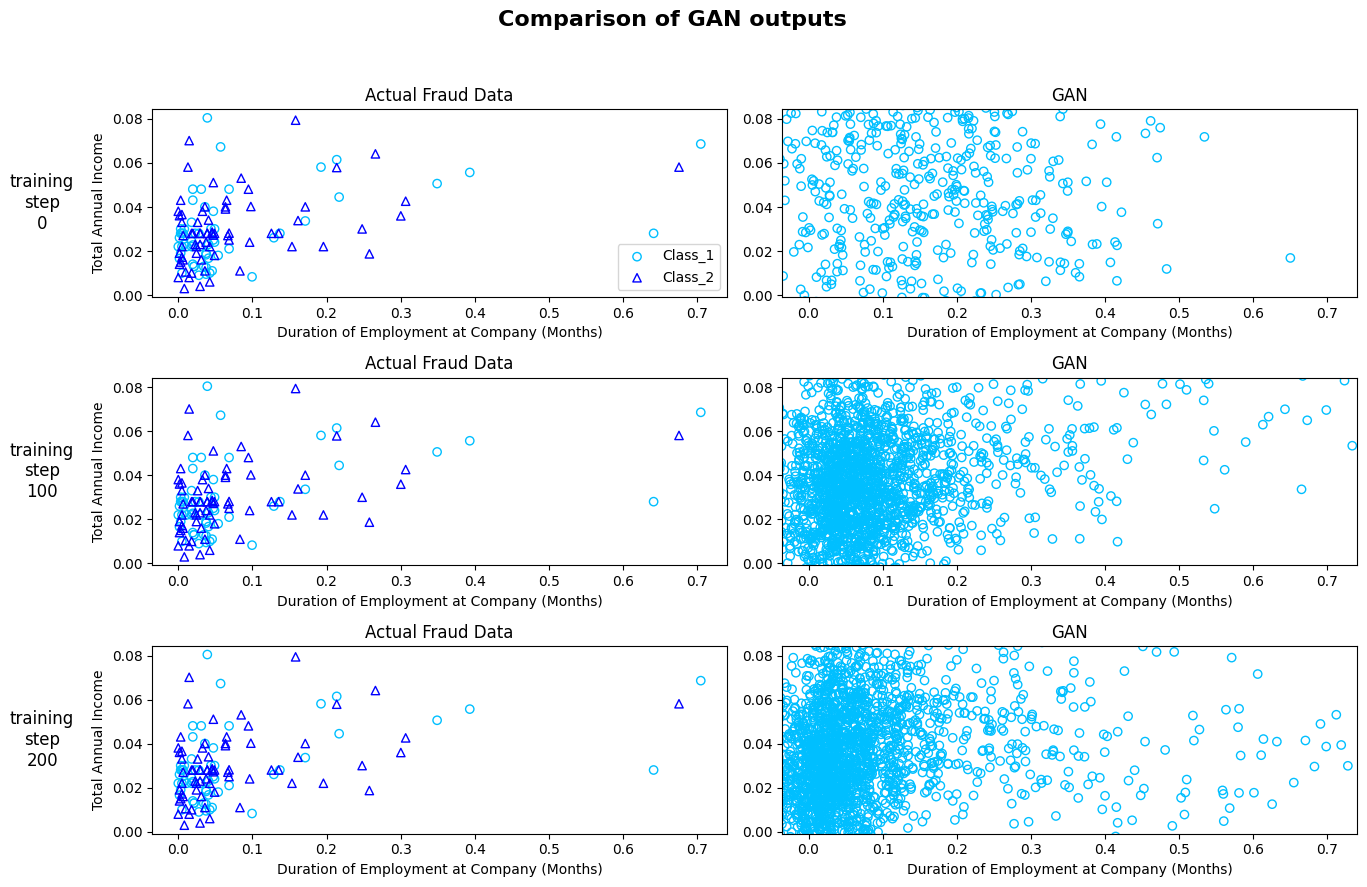

In [ ]:
# Setup parameters visualization parameters
seed = 17
test_size = 2000 # number of fraud cases
noise_dim = 293 ###############

np.random.seed(seed)
z = np.random.normal(size=(test_size, noise_dim))
real_processed = synthesizer.processor.transform(fraud_w_classes)
real_samples = synthesizer.get_data_batch(real_processed, batch_size)
class_labels = ['Class_1','Class_2']
real_samples = pd.DataFrame(real_samples, columns=num_cols+class_labels)
labels = fraud_w_classes['Default 12 Flag']

model_names = ['GAN']
colors = ['deepskyblue','blue']
markers = ['o','^']

col1, col2 = 'Duration of Employment at Company (Months)', 'Total Annual Income'

base_dir = 'cache/'

# Actual fraud data visualization
model_steps = [ 0, 100, 200]
rows = len(model_steps)
columns = 1 + len(models)

axarr = [[]]*len(model_steps)

fig = plt.figure(figsize=(14,rows*3))

# Go through each of the 3 model_step values -> 0, 100, 200
for model_step_ix, model_step in enumerate(model_steps):
    axarr[model_step_ix] = plt.subplot(rows, columns, model_step_ix*columns + 1)

    # Plot 'Class 1' and 'Class 2' samples taken from the original data, in a random shuffled fashion
    for group, color, marker, label in zip(real_samples.groupby('Class_1'), colors, markers, class_labels ):
        plt.scatter( group[1][[col1]], group[1][[col2]],
                         label=label, marker=marker, edgecolors=color, facecolors='none' )

    plt.title('Actual Fraud Data')
    plt.ylabel(col2) # Only add y label to left plot
    plt.xlabel(col1)
    xlims, ylims = axarr[model_step_ix].get_xlim(), axarr[model_step_ix].get_ylim()

    if model_step_ix == 0:
        legend = plt.legend()
        legend.get_frame().set_facecolor('white')

    # Go through all the GAN models listed in 'model_names' and defined in 'models'
    for i, model_name in enumerate( model_names[:] ):

        [model_name, with_class, generator_model] = models[model_name]

        generator_model.load_weights( base_dir + '_generator_model_weights_step_'+str(model_step)+'.h5')

        ax = plt.subplot(rows, columns, model_step_ix*columns + 1 + (i+1) )

        if with_class:
            g_z = generator_model([z, labels])
            gen_samples = pd.DataFrame(g_z, columns=num_cols+class_labels)
            for group, color, marker, label in zip( gen_samples.groupby('Class_1'), colors, markers, class_labels ):
                plt.scatter( group[1][[col1]], group[1][[col2]],
                                 label=label, marker=marker, edgecolors=color, facecolors='none' )
        else:
            g_z = generator_model(z)
            gen_samples = pd.DataFrame(g_z, columns=num_cols+class_labels)
            gen_samples.to_csv('Generated_sample.csv')
            #write_csv(gen_samples, 'Generated_sample.csv')
            plt.scatter( gen_samples[[col1]], gen_samples[[col2]],
                             label=class_labels[0], marker=markers[0], edgecolors=colors[0], facecolors='none' )
        plt.title(model_name)
        plt.xlabel(col1)
        ax.set_xlim(xlims), ax.set_ylim(ylims)

plt.suptitle('Comparison of GAN outputs', size=16, fontweight='bold')
plt.tight_layout(rect=[0.075,0,1,0.95])

# Adding text labels for training steps
vpositions = np.array([ i._position.bounds[1] for i in axarr ])
vpositions += ((vpositions[0] - vpositions[1]) * 0.35 )
for model_step_ix, model_step in enumerate( model_steps ):
    fig.text( 0.05, vpositions[model_step_ix], 'training\nstep\n'+str(model_step), ha='center', va='center', size=12)

if not os.path.exists("./img"):
    os.makedirs("./img")
plt.savefig('img/Comparison_of_GAN_outputs.png', dpi=100)

### Training a HistGradientBoosting Classifier for the trainData combined with synthetic positives

In [ ]:
import pandas as pd
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score
import joblib
import warnings
warnings.filterwarnings("ignore")

### Pipeline to process Data

In [ ]:

# ---------- Robust OneHotEncoder constructor (supports different sklearn versions) ----------
def make_ohe(**kwargs):
    try:
        return OneHotEncoder(**kwargs)
    except TypeError:
        # older sklearn uses 'sparse' instead of 'sparse_output'
        if 'sparse_output' in kwargs:
            kwargs['sparse'] = kwargs.pop('sparse_output')
        return OneHotEncoder(**kwargs)

# ---------- Age transformer (same idea as used before) ----------
class AgeTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, dob_col='Date of Birth', app_col='Application Date', out_col='Age', max_age=120):
        self.dob_col = dob_col
        self.app_col = app_col
        self.out_col = out_col
        self.max_age = max_age
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X = X.copy()
        # Ensure we have a DataFrame
        if not isinstance(X, pd.DataFrame):
            X = pd.DataFrame(X)

        # Safely obtain the date-like series; if absent create NaT series
        app_series = X.get(self.app_col)
        dob_series = X.get(self.dob_col)

        if app_series is None:
            app_dt = pd.Series(pd.NaT, index=X.index)
        else:
            app_dt = pd.to_datetime(app_series, errors='coerce')

        if dob_series is None:
            dob_dt = pd.Series(pd.NaT, index=X.index)
        else:
            dob_dt = pd.to_datetime(dob_series, errors='coerce')

        # Compute difference safely; result may be Timedelta or all NaT
        diff = app_dt - dob_dt
        if hasattr(diff, 'dt'):
            age_series = (diff.dt.days / 365.25).astype(float)
        else:
            age_series = pd.Series(np.nan, index=X.index)

        X[self.out_col] = age_series
        # discard invalid ages
        X.loc[(X[self.out_col] < 0) | (X[self.out_col] > self.max_age), self.out_col] = np.nan
        X[f'{self.out_col}_missing'] = X[self.out_col].isna().astype(int)

        # drop original date columns if present
        for c in (self.dob_col, self.app_col):
            if c in X.columns:
                X.drop(columns=c, inplace=True)
        return X

# ---------- Data references (must exist in the notebook) ----------
# trainData : original training DataFrame (must have label 'Default 12 Flag' and 'ID')
# fraud_w_classes : generated dataset (should have same columns, including 'Default 12 Flag')
# testData : test DataFrame to predict on
# sample_submission.csv is used to preserve output format

# Basic checks
assert 'trainData' in globals(), "trainData not found in notebook"
assert 'synthetic_fraud' in globals(), "synthetic_fraud (synthetic) not found in notebook"
assert 'testData' in globals(), "testData not found in notebook"

train_df = trainData.copy()
synthetic_df = synthetic_fraud.copy()
test_df = testData.copy()

label_col = 'Default 12 Flag'

# for all data in synthetic_fraud set the label as 1
synthetic_df[label_col] = 1

synth_pos = synthetic_df.copy()

# Combine: original train + synthetic positives
combined = pd.concat([train_df, synth_pos], ignore_index=True)
print("Combined shape (train + synthetic positives):", combined.shape)
print("Class distribution after combining:\n", combined[label_col].value_counts())


Combined shape (train + synthetic positives): (130048, 315)
Class distribution after combining:
 Default 12 Flag
0.0    72069
1.0    57979
Name: count, dtype: int64


In [ ]:

# ---------- Columns: try to reuse user-defined lists else infer ----------
try:
    numeric_cols = numericalCol[:]  # copy if defined earlier
except NameError:
    numeric_cols = combined.select_dtypes(include=[np.number]).columns.tolist()
    for c in ['ID', label_col]:
        if c in numeric_cols:
            numeric_cols.remove(c)

try:
    categorical_cols = categoricalCol[:]  # copy if defined earlier
except NameError:
    categorical_cols = [c for c in combined.columns if c not in numeric_cols + ['ID', label_col] and combined[c].dtype == 'object']

# Ensure 'Age' is present as a numeric feature after AgeTransformer runs
if 'Age' not in numeric_cols:
    numeric_cols = numeric_cols + ['Age']

print("Using numeric cols (sample):", numeric_cols[:8])
print("Using categorical cols (sample):", categorical_cols[:8])

# ---------- Preprocessing pipelines ----------
numeric_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

ohe = make_ohe(handle_unknown='ignore', sparse_output=False)   # set sparse_output=True for sparse result if needed
categorical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', ohe)
])

preprocessor = ColumnTransformer([
    ('num', numeric_pipeline, numeric_cols),
    ('cat', categorical_pipeline, categorical_cols)
], remainder='drop')

# ---------- Full pipeline: Age -> preprocess -> HistGradientBoostingClassifier ----------
clf = HistGradientBoostingClassifier(max_iter=100, random_state=0)

pipeline = Pipeline([
    ('age', AgeTransformer()),   # creates Age and Age_missing, drops original dates
    ('preproc', preprocessor),
    ('clf', clf)
])


Using numeric cols (sample): ['Declared Amount of Unsecured Loans', 'Number of Unsecured Loans', 'Number of Dependents', 'Number of Dependent Children', 'Rent Burden Amount', 'Duration of Residence (Months)', 'Duration of Employment at Company (Months)', 'Total Annual Income']
Using categorical cols (sample): ['Major Media Code', 'Internet Details', 'Reception Type Category', 'Gender', 'Single/Married Status', 'Residence Type', 'Name Type', 'Family Composition Type']


In [ ]:
print(synth_pos.shape)
for col in synth_pos.columns:
    print(f"{col}: {synth_pos[col].dtype}")

(50048, 295)
Number of Dependents: float64
Number of Dependent Children: float64
JIS Address Code: float64
Rent Burden Amount: float64
Duration of Residence (Months): float64
Duration of Employment at Company (Months): float64
Total Annual Income: float64
Declared Number of Unsecured Loans: float64
Declared Amount of Unsecured Loans: float64
Number of Unsecured Loans: float64
Amount of Unsecured Loans: float64
Application Limit Amount(Desired): float64
Default 12 Flag: int64
Age: float64
is_weekend: int32
Application_Month: int32
Debt_to_Income: float64
Loan_Count_per_Dependent: float64
Rent_to_Income: float64
Loan_Amount_per_Income: float64
Declared_Loan_Amount_Diff: float64
Declared_Loan_Count_Diff: float64
Desired_Credit_to_Income: float64
Employment_Tenure_to_Age: float64
Children_to_Dependent_Ratio: float64
Household_Size: float64
Income_per_Month_Employment: float64
Major Media Code_1: float64
Major Media Code_2: float64
Major Media Code_3: float64
Major Media Code_5: float64
Maj

### Cross Validation

In [ ]:

# ---------- Prepare X, y ----------
X_comb = combined.drop(columns=[label_col])
y_comb = combined[label_col].astype(int)

# Optional: quick CV to sanity-check (Stratified 5-fold ROC AUC)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
print("Running 5-fold CV (ROC AUC) on combined data (this may take a while)...")
cv_scores = cross_val_score(pipeline, X_comb, y_comb, cv=cv, scoring='roc_auc', n_jobs=-1)
print("CV ROC AUC scores:", np.round(cv_scores, 4))
print("Mean CV ROC AUC:", cv_scores.mean())


Running 5-fold CV (ROC AUC) on combined data (this may take a while)...
CV ROC AUC scores: [0.9532 0.9519 0.9544 0.954  0.9533]
Mean CV ROC AUC: 0.9533401482177044


### Model Fitting

In [ ]:
pipeline.fit(X_comb, y_comb)
joblib.dump(pipeline, 'models/hgb_pipeline_combined.joblib')
print("Fitted HistGradientBoostingClassifier pipeline saved to 'hgb_pipeline_combined.joblib'")

Fitted HistGradientBoostingClassifier pipeline saved to 'hgb_pipeline_combined.joblib'


## Test the Model

In [ ]:
# ---------- Predict probabilities on test set ----------
# Prepare test X (drop label if present)
test_X = test_df.copy()
if label_col in test_X.columns:
    test_X = test_X.drop(columns=[label_col])

probs = pipeline.predict_proba(test_X)[:, 1]  # probability of class 1

# ---------- Prepare submission in same format as sample_submission.csv ----------
sample_sub = pd.read_csv('data/sample_submission.csv')
submission = sample_sub.copy()

# Assume second column is the probability column to fill
if submission.shape[1] >= 2:
    prob_col = submission.columns[1]
else:
    # fallback name
    prob_col = 'Probability'

submission[prob_col] = probs

# Align ID column if present in sample submission and test_df
id_col_sample = submission.columns[0]
if 'ID' in test_df.columns:
    submission[id_col_sample] = test_df['ID'].values
elif id_col_sample in test_df.columns:
    submission[id_col_sample] = test_df[id_col_sample].values
# else keep sample's ID column as-is (or numeric index)

submission.to_csv('my_submission.csv', index=False)
print("Wrote submission to 'my_submission.csv'. Preview:")
print(submission.head())

Wrote submission to 'my_submission.csv'. Preview:
             ID  Default 12 Flag
0  202511080001         0.057976
1  202511080002         0.071193
2  202511080003         0.065964
3  202511080004         0.039177
4  202511080005         0.067624
